In [1]:
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## k-fold Cross Validation

In [2]:
dl_train = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/mnist', train=True, download=True))

dl_test  = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/mnist', train=False, download=True))

In [3]:
data   = dl_train.dataset.data.to(dtype=torch.float32)/255.0
labels = dl_train.dataset.targets

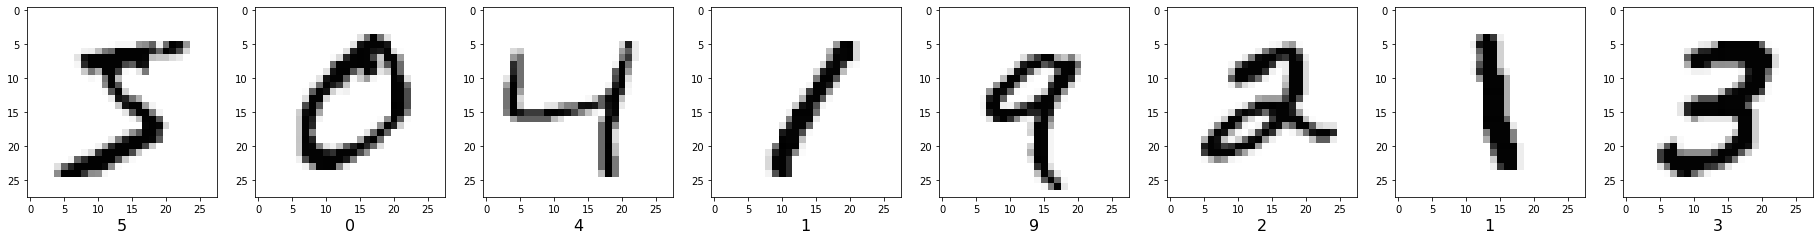

In [4]:
fig_mnist, ax = plt.subplots(1,8, figsize=(8*4,4))
for i in range(8):
    ax[i].imshow(data[i].numpy(), cmap='Greys');
    ax[i].set_xlabel("%d" % (labels[i],), fontsize=16)

In [5]:
by_labels = [data[labels==i] for i in range(10)]

In [6]:
small_data  = torch.cat([by_labels[i][np.random.choice(len(by_labels[i]),100, replace=False)] for i in range(10)],0)

In [7]:
small_data.shape

torch.Size([1000, 28, 28])

In [8]:
small_labels = torch.cat([i*torch.ones(100, dtype=torch.int64) for i in range(10)])

In [9]:
perm = np.random.choice(len(small_data), len(small_data), replace=False)

In [10]:
shuffled_data = small_data[perm]
shuffled_labels = small_labels[perm]

In [11]:
data_folds  = torch.stack(torch.chunk(shuffled_data,5))
label_folds = torch.stack(torch.chunk(shuffled_labels,5))

In [12]:
 loss_f = nn.CrossEntropyLoss()

In [13]:
def make_model():
    return torch.nn.Sequential(
        nn.Linear(28*28,1200), nn.ReLU(), nn.Linear(1200,1200), nn.ReLU(),
        nn.Linear(1200,1200), nn.ReLU(),nn.Linear(1200,10)
    )

In [14]:
 for lr in [0.0001, 0.001, 0.01 , 0.05, 0.1, 0.2, 0.5, 1.0]: 
    avg_ac = 0.0    
    for i in range(5):
        chunks = list(range(5))
        chunks.remove(i)
        kData    = data_folds[chunks].reshape(-1,28*28)
        kLabels   = label_folds[chunks].reshape(-1)

        dataset = torch.utils.data.TensorDataset(kData, kLabels)
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)
        model = make_model()
        optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.6)
        
        for e in range(50):
            for d in train_loader:        
                optim.zero_grad()
                features, labels = d
                pred = model(features)
                loss = loss_f(pred, labels)
                loss.backward()
                optim.step()
        with torch.no_grad():
            pred = torch.softmax(model(data_folds[i].view(-1,28*28)),1)
            ac = torch.sum(torch.argmax(pred,1)==label_folds[i]).to(dtype=torch.float32)/len(label_folds[i])
            avg_ac += ac
            #print(i, ac)
    print(lr, avg_ac/5.0)        

0.0001 tensor(0.1240)
0.001 tensor(0.3160)
0.01 tensor(0.8560)
0.05 tensor(0.8780)
0.1 tensor(0.8770)
0.2 tensor(0.8930)
0.5 tensor(0.7230)
1.0 tensor(0.1030)


In [18]:
 for t in range(8):
    u = np.random.uniform(-3,-1)
    lr = np.exp(u)
    avg_ac = 0.0    
    for i in range(5):
        chunks = list(range(5))
        chunks.remove(i)
        kData    = data_folds[chunks].reshape(-1,28*28)
        kLabels   = label_folds[chunks].reshape(-1)

        dataset = torch.utils.data.TensorDataset(kData, kLabels)
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)
        model = make_model()
        optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.6)
        
        for e in range(50):
            for d in train_loader:        
                optim.zero_grad()
                features, labels = d
                pred = model(features)
                loss = loss_f(pred, labels)
                loss.backward()
                optim.step()
        with torch.no_grad():
            pred = torch.softmax(model(data_folds[i].view(-1,28*28)),1)
            ac = torch.sum(torch.argmax(pred,1)==label_folds[i]).to(dtype=torch.float32)/len(label_folds[i])
            avg_ac += ac
            #print(i, ac)
    print(lr, avg_ac/5.0)        

0.07176781504885694 tensor(0.8820)
0.08307762061374135 tensor(0.8830)
0.08881066843071779 tensor(0.8800)
0.09158548225254944 tensor(0.8820)
0.2183274100645438 tensor(0.8960)
0.06508800363864217 tensor(0.8810)
0.059907634358654045 tensor(0.8780)
0.10057267866203423 tensor(0.8850)


![](random_search.png)